# AutoML 심화 - 사고 데이터에 AutoGluon 적용

이 노트북에서는 **대구 교통사고 데이터셋**에 AutoGluon을 적용하여
AutoML의 성능을 검증하고, 수동 모델링과 비교해봅니다.

## 학습 목표
1. 사고 데이터셋에 AutoGluon 적용하기
2. train/valid 분리 후 RMSLE로 성능 검증
3. 전체 train 데이터로 재학습 후 test 예측
4. 수동 모델링(3일차)과 AutoML 결과 비교

## AutoML 장점
- 범주형 변수 자동 처리 (Label Encoding 불필요)
- 다양한 모델 자동 학습 및 앙상블
- 하이퍼파라미터 튜닝 자동화

## AutoML 한계
- 블랙박스 특성으로 해석이 어려움
- 도메인 지식 반영이 제한적
- 학습 시간이 길어질 수 있음

## 사용 데이터
- `train.csv`: 대구 교통사고 학습 데이터
- `test.csv`: 예측 대상 데이터
- 타깃: ECLO (Equivalent Casualty Level of Object)

## 실습 환경
- Google Colab
- Python 3.x

In [ ]:
# ==========================================
# 0. 한글 출력을 위한 기초 셀
#    (코랩에서 한 번만 실행하면 이후 그래프에 한글이 깨지지 않도록 설정)
#    참조: https://conding-note.tistory.com/335
# ==========================================

!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib as mpl
print("matplotlibrc 경로:", mpl.matplotlib_fname())

import shutil
import matplotlib as mpl

# matplotlib 설정 파일(matplotlibrc)의 경로에서 루트 디렉토리만 추출
# 예) /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/matplotlibrc
#  → /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/
root = mpl.matplotlib_fname().replace("matplotlibrc", "")

# matplotlib 기본 폰트 파일(DejaVuSans.ttf)이 위치한 경로
target_font = root + "fonts/ttf/DejaVuSans.ttf"
print("matplotlib 기본 폰트 파일:", target_font)

# 나눔고딕 폰트 경로 (Ubuntu/Colab에서 설치되는 경로)
nanum_font = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# shutil.copyfile:
# - 파일을 다른 경로로 복사하는 함수
# - 여기서는 DejaVuSans.ttf 파일을 나눔고딕으로 교체하여
#   matplotlib의 기본 폰트를 나눔고딕으로 바꿉니다.
shutil.copyfile(nanum_font, target_font)
print("기본 폰트를 나눔고딕으로 교체 완료")

# matplotlib 캐시 삭제
# - 캐시에 이전 폰트 정보가 남아 있으면 새 폰트가 바로 적용되지 않을 수 있어
#   캐시를 삭제하여 강제로 다시 로딩하도록 합니다.
!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일을 'whitegrid'로 지정 (흰 배경 + 그리드)
sns.set(style="whitegrid")

# 테스트 플롯 (한글 출력 확인)
plt.figure(figsize=(4,3))
plt.title("한글 폰트 정상 출력 확인")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([1,2,3], [1,4,2])
plt.show()


In [ ]:
# ============================================================
# 0. 환경 설정 및 기본 로드
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# 1) gdown 설치 (한 번만 실행)
!pip install -q gdown

# 2) 구글 드라이브에서 데이터 zip 파일 다운로드
#   - id 뒤에 있는 값이 링크의 파일 ID입니다.
#   - 필요하면 파일 이름(accident_dataset.zip)만 바꿔서 쓰시면 됩니다.

FILE_ID = "1eAhZ43YHpIj1OQ5s3DVTh4tu1eWs6cos"
OUTPUT_ZIP = "accident_dataset.zip"

!gdown --id {FILE_ID} -O {OUTPUT_ZIP}

# 3) 압축 해제
#   - accident_dataset 폴더 아래에 내용을 풀어놓습니다.
#   - 압축이 zip이 아니라면 확장자에 맞게 unzip 대신 다른 명령을 쓰셔야 합니다.

!mkdir -p accident_dataset
!unzip -q {OUTPUT_ZIP} -d accident_dataset

# 잘 풀렸는지 확인
!ls -R accident_dataset



/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eAhZ43YHpIj1OQ5s3DVTh4tu1eWs6cos
To: /content/accident_dataset.zip
100% 16.8M/16.8M [00:00<00:00, 50.0MB/s]
accident_dataset:
open

accident_dataset/open:
external_open  sample_submission.csv  test.csv	train.csv

accident_dataset/open/external_open:
'대구 CCTV 정보.csv'		  '대구 보안등 정보.csv'
 countrywide_accident.csv	  '대구 주차장 정보.csv'
'대구 어린이 보호 구역 정보.csv'


In [ ]:
def read_csv_safe(path):
    """
    여러 인코딩 후보를 시도하며 CSV를 안전하게 읽는 헬퍼 함수
    """
    for enc in ["utf-8", "utf-8-sig", "cp949"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError(f"Could not read file: {path}")

# Colab 기준 경로 (필요시 수정)
train_path  = "/content/accident_dataset/open/train.csv"
test_path   = "/content/accident_dataset/open/test.csv"
sample_path = "/content/accident_dataset/open/sample_submission.csv"

train = read_csv_safe(train_path)
test  = read_csv_safe(test_path)
sample = read_csv_safe(sample_path)

print("train.shape:", train.shape)
print("test.shape :", test.shape)
print("sample.shape:", sample.shape)

print("\n[train columns]")
print(train.columns.tolist())

print("\n[train dtypes]")
print(train.dtypes)

train.shape: (39609, 23)
test.shape : (10963, 8)
sample.shape: (10963, 2)


               사망자수          중상자수          경상자수          부상자수          ECLO
count  39609.000000  39609.000000  39609.000000  39609.000000  39609.000000
mean       0.007776      0.262365      1.070085      0.126865      4.726704
std        0.090109      0.500845      0.992034      0.394670      3.207206
min        0.000000      0.000000      0.000000      0.000000      1.000000
25%        0.000000      0.000000      0.000000      0.000000      3.000000
50%        0.000000      0.000000      1.000000      0.000000      3.000000
75%        0.000000      0.000000      1.000000      0.000000      6.000000
max        2.000000      6.000000     22.000000     10.000000     74.000000

[결측치 개수]
ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해

/tmp/ipython-input-990392906.py:15: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-990392906.py:15: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-990392906.py:15: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-990392906.py:15: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-pack

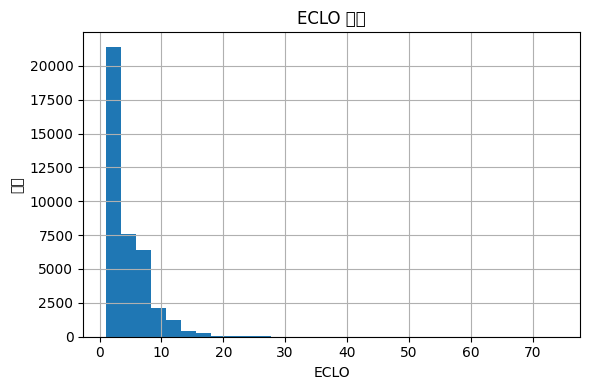

/tmp/ipython-input-990392906.py:23: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-990392906.py:23: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-990392906.py:23: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-990392906.py:23: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


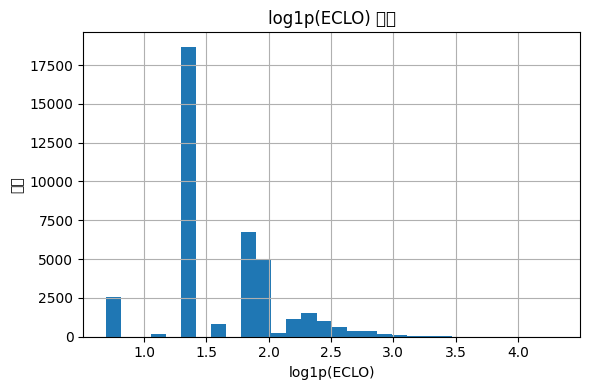

In [ ]:
# ============================================================
# 2. 간단 EDA
# ============================================================

print(train.describe())

print("\n[결측치 개수]")
print(train.isnull().sum())

plt.figure(figsize=(6, 4))
train["ECLO"].hist(bins=30)
plt.title("ECLO 분포")
plt.xlabel("ECLO")
plt.ylabel("건수")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
np.log1p(train["ECLO"]).hist(bins=30)
plt.title("log1p(ECLO) 분포")
plt.xlabel("log1p(ECLO)")
plt.ylabel("건수")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 3. 날짜 파생 변수 및 시간대 생성
# ============================================================

train["사고일시"] = pd.to_datetime(train["사고일시"])
test["사고일시"]  = pd.to_datetime(test["사고일시"])

for df in [train, test]:
    df["사고연"] = df["사고일시"].dt.year
    df["사고월"] = df["사고일시"].dt.month
    df["사고일"] = df["사고일시"].dt.day
    df["사고시"] = df["사고일시"].dt.hour

def hour_to_period(h):
    if 7 <= h <= 9:
        return "출근시간대"
    elif 17 <= h <= 19:
        return "퇴근시간대"
    elif 22 <= h or h <= 5:
        return "심야"
    else:
        return "일반시간대"

for df in [train, test]:
    df["시간대"] = df["사고시"].apply(hour_to_period)


In [ ]:
# ============================================================
# 4. 피처 선택 (train/test 공통 컬럼 + 누수 제거)
# ============================================================

target_col = "ECLO"
id_col = "ID"

# train/test 공통 컬럼
common_cols = sorted(list(set(train.columns) & set(test.columns)))
print("train/test 공통 컬럼 수:", len(common_cols))
print("train/test 공통 컬럼 예시:", common_cols[:10])

# 기본 피처: 공통 컬럼에서 ID 제거
feature_cols = [c for c in common_cols if c != id_col]

# ECLO 구성 요소(사상자 수)는 누수 위험이므로 방어적으로 제거 (공통이면 제거)
leakage_cols = ["사망자수", "중상자수", "경상자수", "부상자수"]
feature_cols = [c for c in feature_cols if c not in leakage_cols]

# 원본 사고일시는 파생 피처로 대체
if "사고일시" in feature_cols:
    feature_cols.remove("사고일시")

print("최종 사용할 피처 수:", len(feature_cols))
print("피처 목록:", feature_cols)


train/test 공통 컬럼 수: 13
train/test 공통 컬럼 예시: ['ID', '기상상태', '노면상태', '도로형태', '사고시', '사고연', '사고월', '사고유형', '사고일', '사고일시']
최종 사용할 피처 수: 11
피처 목록: ['기상상태', '노면상태', '도로형태', '사고시', '사고연', '사고월', '사고유형', '사고일', '시간대', '시군구', '요일']


In [ ]:
# ============================================================
# 5. AutoGluon용 데이터셋 구성 (전처리 동일, 인코딩은 AutoGluon에 위임)
# ============================================================

# AutoGluon은 범주형 object 컬럼을 자체 처리하므로 별도 Label Encoding 불필요
data_ag = train[feature_cols + [target_col]].copy()
test_ag = test[feature_cols].copy()

print("data_ag shape:", data_ag.shape)
print("test_ag shape:", test_ag.shape)


data_ag shape: (39609, 12)
test_ag shape: (10963, 11)


In [ ]:
# ============================================================
# 6. train/valid 분리 + RMSLE 함수 정의
# ============================================================

train_ag, valid_ag = train_test_split(
    data_ag, test_size=0.2, random_state=42
)

print("AutoGluon train:", train_ag.shape)
print("AutoGluon valid:", valid_ag.shape)

def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


AutoGluon train: (31687, 12)
AutoGluon valid: (7922, 12)


In [ ]:
# ============================================================
# 7. AutoGluon 설치 및 학습
# ============================================================

!pip install -q autogluon.tabular

from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(
    label=target_col,
).fit(
    train_data=train_ag,
    time_limit=600,          # 필요 시 조정
    presets="best_quality"   # 또는 "medium_quality_faster_train"
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00


No path specified. Models will be saved in: "AutogluonModels/ag-20251118_131518"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       11.17 GB / 12.67 GB (88.1%)
Disk Space Avail:   69.25 GB / 107.72 GB (64.3%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_l

In [ ]:
# ============================================================
# 8. 검증 세트 성능 평가 (RMSLE)
# ============================================================

X_valid_ag = valid_ag.drop(columns=[target_col])
y_valid_ag = valid_ag[target_col]

pred_valid_ag = predictor.predict(X_valid_ag)

score_ag = rmsle(y_valid_ag.values, pred_valid_ag.values)
print("AutoGluon RMSLE (valid):", score_ag)

# 리더보드(내부 평가 결과)도 참고 가능
leaderboard = predictor.leaderboard(valid_ag, silent=True)
leaderboard.head()


AutoGluon RMSLE (valid): 0.5141682602909898


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L1,0.473744,0.473348,accuracy,4.366864,0.690542,266.760966,4.366864,0.690542,266.760966,1,True,1
1,WeightedEnsemble_L3,0.473744,0.473348,accuracy,4.370832,0.698025,267.633390,0.003968,0.007483,0.872424,3,True,5
2,WeightedEnsemble_L2,0.473744,0.473348,accuracy,4.371515,0.697461,267.605113,0.004651,0.006919,0.844146,2,True,3
3,LightGBMXT_BAG_L1,0.473365,0.472211,accuracy,7.833403,2.237150,26.980086,7.833403,2.237150,26.980086,1,True,2
4,NeuralNetFastAI_BAG_L2,0.473365,0.472179,accuracy,13.495122,3.614698,430.764150,1.294855,0.687005,137.023098,2,True,4


In [ ]:
# ============================================================
# 9. 전체 train으로 재학습 후 test 예측 및 제출 파일 생성
# ============================================================

# 전체 data_ag로 다시 학습
predictor_full = TabularPredictor(
    label=target_col,
).fit(
    train_data=data_ag,
    time_limit=600,
    presets="best_quality"
)

# test 예측
pred_test_ag = predictor_full.predict(test_ag)
pred_test_ag = np.maximum(pred_test_ag, 0)

submission_ag = sample.copy()
submission_ag["ECLO"] = pred_test_ag.values

submission_ag_file = "submission_train_only_autogluon.csv"
submission_ag.to_csv(submission_ag_file, index=False)
print(f"AutoGluon 제출 파일 저장 완료: {submission_ag_file}")


No path specified. Models will be saved in: "AutogluonModels/ag-20251118_132532"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.86 GB / 12.67 GB (85.7%)
Disk Space Avail:   69.18 GB / 107.72 GB (64.2%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_l

KeyboardInterrupt: 